In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda
Epoch 001 | MSE=6373.653989
Epoch 002 | MSE=4237.193623
Epoch 003 | MSE=2859.120874
Epoch 004 | MSE=1877.833712
Epoch 005 | MSE=1190.995931
Epoch 006 | MSE=729.093901
Epoch 007 | MSE=428.864052
Epoch 008 | MSE=243.441326
Epoch 009 | MSE=134.854914
Epoch 010 | MSE=74.543853
Epoch 011 | MSE=43.183299
Epoch 012 | MSE=27.721865
Epoch 013 | MSE=20.585503
Epoch 014 | MSE=17.684815
Epoch 015 | MSE=16.416703
Epoch 016 | MSE=15.872333
Epoch 017 | MSE=15.753629
Epoch 018 | MSE=15.697933
Epoch 019 | MSE=15.763206
Epoch 020 | MSE=15.804700
Epoch 021 | MSE=15.642705
Epoch 022 | MSE=15.630090
Epoch 023 | MSE=15.704370
Epoch 024 | MSE=15.734548
Epoch 025 | MSE=15.585360
Epoch 026 | MSE=15.783486
Epoch 027 | MSE=15.644252
Epoch 028 | MSE=15.713148
Epoch 029 | MSE=15.690062
Epoch 030 | MSE=15.700709

=========== Block Missing Debug (LSTM) ===========
Deleted indices : [23, 24, 25, 26, 27]
True values     : [89.78559875488281, 89.48159790039062, 89.64949798583984, 89.76640319824219, 89.6011

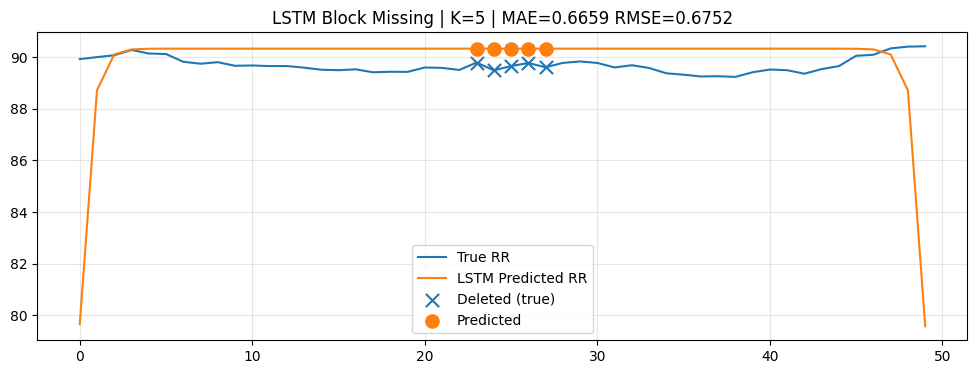

Saved LSTM model.


In [7]:
# ============================================================
# LSTM BASELINE — BLOCK MISSINGNESS (NO GAN)
# RR Interval Imputation
#
# - BLOCK missingness (K consecutive points)
# - Mean fill ONLY as input (not reported)
# - LSTM predicts full sequence
# - Evaluation ONLY on missing points
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

# -------------------------
# CONFIG
# -------------------------
WINDOW_LEN = 50
STRIDE     = 5
K_MISSING  = 5   # block length

BATCH_SIZE = 128
EPOCHS     = 30
LR         = 1e-3
SEED       = 42

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Dummy RR records (REPLACE with your real rr_records)
# ============================================================
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)
    rr_records.append(base.astype(np.float32))

# ============================================================
# Dataset
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for r in rr_records:
            for i in range(0, len(r) - window_len + 1, stride):
                self.samples.append(r[i:i+window_len])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# BLOCK missing mask + mean fill (input only)
# ============================================================
def make_block_missing(x, K):
    """
    x: (B,T)
    """
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_list = []

    for b in range(B):
        start = torch.randint(0, T-K+1, (1,)).item()
        idx = torch.arange(start, start+K)
        m[b, idx] = 0
        idx_list.append(idx)

    # Mean fill (input only)
    obs_sum = (x * m).sum(dim=1, keepdim=True)
    obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1)
    fill = obs_sum / obs_cnt
    x_filled = x * m + fill * (1 - m)

    return x_filled, m, idx_list

# ============================================================
# LSTM Model
# ============================================================
class LSTMImputer(nn.Module):
    def __init__(self, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x):
        # x: (B,T)
        h, _ = self.lstm(x.unsqueeze(-1))
        return self.fc(h).squeeze(-1)

# ============================================================
# Train
# ============================================================
def train_lstm(rr_records):
    ds = RRWindowDataset(rr_records, WINDOW_LEN, STRIDE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = LSTMImputer().to(device)
    opt = optim.Adam(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train()
        loss_sum = 0

        for x in dl:
            x = x.to(device)
            x_fill, m, _ = make_block_missing(x, K_MISSING)

            pred = model(x_fill)

            # Missing-only loss
            loss = ((pred - x)**2 * (1-m)).sum() / (1-m).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {ep:03d} | MSE={loss_sum/len(dl):.6f}")

    return model

# ============================================================
# Inference + Debug
# ============================================================
@torch.no_grad()
def evaluate_one(model, rr_window):
    model.eval()

    x = torch.tensor(rr_window).unsqueeze(0).to(device)
    x_fill, m, idx_list = make_block_missing(x, K_MISSING)
    idx = idx_list[0].cpu().numpy()

    pred = model(x_fill).cpu().numpy()[0]
    true = rr_window

    err = np.abs(pred[idx] - true[idx])
    mae = err.mean()
    rmse = np.sqrt((err**2).mean())

    print("\n=========== Block Missing Debug (LSTM) ===========")
    print("Deleted indices :", idx.tolist())
    print("True values     :", np.round(true[idx],4).tolist())
    print("Predicted       :", np.round(pred[idx],4).tolist())
    print("Abs error       :", np.round(err,4).tolist())
    print(f"LSTM -> MAE={mae:.4f} | RMSE={rmse:.4f}")
    print("=================================================\n")

    return true, x_fill.cpu().numpy()[0], pred, idx, mae, rmse

# ============================================================
# Plot
# ============================================================
def plot_result(true, filled, pred, idx, title):
    plt.figure(figsize=(12,4))
    plt.plot(true, label="True RR")
    plt.plot(pred, label="LSTM Predicted RR")
    plt.scatter(idx, true[idx], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx, pred[idx], marker="o", s=90, label="Predicted")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(title)
    plt.show()

# ============================================================
# RUN
# ============================================================
model = train_lstm(rr_records)

test_seq = rr_records[0][:WINDOW_LEN]
true, filled, pred, idx, mae, rmse = evaluate_one(model, test_seq)

plot_result(
    true, filled, pred, idx,
    title=f"LSTM Block Missing | K={K_MISSING} | MAE={mae:.4f} RMSE={rmse:.4f}"
)

torch.save(model.state_dict(), "/kaggle/working/lstm_rr_block_missing.pt")
print("Saved LSTM model.")
